In [ ]:
Reference: https://www.tensorflow.org/tutorials/text/word2vec

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import io
import itertools
import numpy as np
import os
import re
import string
import tensorflow as tf
import tqdm

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Dot, Embedding, Flatten, GlobalAveragePooling1D, Reshape
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
SEED = 42 
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# You may load this given csv, or you may change this line to load some other csv
df = pd.read_csv('https://raw.githubusercontent.com/amey-kulkarni27/Datasets/main/images.csv')

## Text Standardisation
Converting text to lower case, removing punctuation, etc.

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')

In [ ]:
df_stand = df['description'].apply(custom_standardization)

In [ ]:
df_stand

0        tf.Tensor(b'nayo women orange  offwhite stripe...
1        tf.Tensor(b'jaipur kurti women navy blue yoke ...
2        tf.Tensor(b'ahika women green  offwhite printe...
3        tf.Tensor(b'ada women yellow  white chikankari...
4        tf.Tensor(b'soch women navy blue  grey dyed st...
                               ...                        
12300    tf.Tensor(b'saree swarg blue  orange checked b...
12301    tf.Tensor(b'tikhi imli beige  red poly silk pr...
12302    tf.Tensor(b'mitera pink  goldtoned silk blend ...
12303    tf.Tensor(b'saree mall pink  golden woven desi...
12304    tf.Tensor(b'kalakari india blue  white dabu ha...
Name: description, Length: 12305, dtype: object

In [ ]:
vocab_size = 1394
sequence_length = 5
num_ns = 4

## Vectorisation and Inverse Vocabulary

In [ ]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
text_dataset = tf.data.Dataset.from_tensor_slices(list(df_stand))

In [ ]:
text_dataset

<TensorSliceDataset shapes: (), types: tf.string>

In [ ]:
vectorize_layer.adapt(text_dataset.batch(1024))

In [ ]:
inverse_vocab = vectorize_layer.get_vocabulary()

In [ ]:
print(len(inverse_vocab))

1394


In [ ]:
text_vector_ds = text_dataset.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

In [ ]:
sequences = list(text_vector_ds.as_numpy_iterator())
len(sequences)

12305

In [ ]:
for seq in sequences[:5]:
  print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[147   8  50  46  43  15   4   0   0   0   0   0] => ['nayo', 'women', 'orange', 'offwhite', 'striped', 'straight', 'kurta', '', '', '', '', '']
[205 198   8  19   6 164  10   4   9 108   0   0] => ['jaipur', 'kurti', 'women', 'navy', 'blue', 'yoke', 'design', 'kurta', 'with', 'trousers', '', '']
[451   8  16  46   5  15   4   0   0   0   0   0] => ['ahika', 'women', 'green', 'offwhite', 'printed', 'straight', 'kurta', '', '', '', '', '']
[493   8  26  13 408 213  38 428  15   4   0   0] => ['ada', 'women', 'yellow', 'white', 'chikankari', 'hand', 'embroidered', 'semisheer', 'straight', 'kurta', '', '']
[196   8  19   6  30 214  15   4   0   0   0   0] => ['soch', 'women', 'navy', 'blue', 'grey', 'dyed', 'straight', 'kurta', '', '', '', '']


##Training Data
 Generates skip-gram pairs with negative sampling for a list of sequences(int-encoded sentences) based on window size, number of negative samples and vocabulary size.

In [ ]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for vocab_size tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence, 
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples 
    # with positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1, 
          num_sampled=num_ns, 
          unique=True, 
          range_max=vocab_size, 
          seed=SEED, 
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      negative_sampling_candidates = tf.expand_dims(
          negative_sampling_candidates, 1)

      context = tf.concat([context_class, negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [ ]:
targets, contexts, labels = generate_training_data(
    sequences=sequences, 
    window_size=4, 
    num_ns=4, 
    vocab_size=vocab_size, 
    seed=SEED)
print(len(targets), len(contexts), len(labels))

100%|██████████| 12305/12305 [00:02<00:00, 4410.94it/s]

26249 26249 26249


In [ ]:
BATCH_SIZE = 512
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: (((512,), (512, 5, 1)), (512, 5)), types: ((tf.int32, tf.int64), tf.int64)>


In [ ]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset shapes: (((512,), (512, 5, 1)), (512, 5)), types: ((tf.int32, tf.int64), tf.int64)>


## Model

In [ ]:
class Word2Vec(Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = Embedding(vocab_size, 
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding", )
    self.context_embedding = Embedding(vocab_size, 
                                       embedding_dim, 
                                       input_length=num_ns+1,
                                       name = "ctxt_embedding")
    self.dots = Dot(axes=(3,2))
    self.flatten = Flatten()

  def call(self, pair):
    target, context = pair
    we = self.target_embedding(target)
    ce = self.context_embedding(context)
    dots = self.dots([ce, we])
    return self.flatten(dots)


In [ ]:
embedding_dim = 512
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [ ]:
word2vec.fit(dataset, epochs=1000, callbacks=[tensorboard_callback])

Epoch 1/1000
51/51 [==============================] - 1s 26ms/step - loss: 0.7284 - accuracy: 0.7549
Epoch 2/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.6535 - accuracy: 0.7804
Epoch 3/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.5963 - accuracy: 0.8018
Epoch 4/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.5490 - accuracy: 0.8163
Epoch 5/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.5098 - accuracy: 0.8296
Epoch 6/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4769 - accuracy: 0.8416
Epoch 7/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4493 - accuracy: 0.8514
Epoch 8/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4260 - accuracy: 0.8580
Epoch 9/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.4061 - accuracy: 0.8640
Epoch 10/1000
51/51 [==============================] - 1s 21ms/step - loss: 0.3891 - accura

In [ ]:
weights1 = word2vec.get_layer('w2v_embedding').get_weights()[0]
weights2 = word2vec.get_layer('ctxt_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

### Having a look at the weight vectors

In [ ]:
pd.DataFrame(weights1).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,-0.025069,-0.000066,-0.031654,0.014237,-0.023404,0.016262,0.000415,0.037340,0.025396,0.031867,-0.047326,0.047726,0.036843,-0.045014,0.013775,0.005584,-0.007188,0.040271,-0.040543,-0.037266,0.039560,0.046198,-0.030002,-0.002558,-0.032246,-0.027968,-0.021535,-0.021913,0.003012,-0.005837,-0.037709,-0.001804,0.034664,0.041707,0.026736,0.005130,0.014264,-0.040133,0.039527,0.003013,...,-0.004466,0.010940,0.008247,-0.018976,0.049164,-0.013599,-0.019706,-0.041574,-0.045537,0.024910,0.034660,0.016334,0.018006,0.012014,-0.039957,-0.021537,-0.025172,-0.008531,0.029554,-0.046537,0.033630,0.029231,-0.029821,0.038628,-0.034763,0.040339,0.006135,-0.037127,-0.034391,0.019031,0.043469,0.021912,0.033245,-0.041135,0.033065,0.026778,-0.000642,-0.041829,0.043674,0.017925
1,0.033276,-0.040155,0.039880,-0.037529,-0.021232,-0.046790,-0.014804,-0.000618,0.033305,0.037357,0.023398,-0.025480,0.023055,-0.021867,0.030498,-0.007698,-0.045484,0.003096,-0.007141,0.030076,-0.025715,-0.019170,0.032367,0.048124,0.010594,0.014132,-0.011346,-0.032680,-0.033209,0.009414,0.049307,-0.043517,0.037503,-0.009895,-0.036917,0.029667,-0.030794,-0.030562,0.006142,-0.036629,...,-0.018165,-0.010695,-0.043080,0.003355,-0.034861,0.025250,-0.020540,-0.005703,0.005456,-0.013887,-0.001461,0.020453,0.038282,0.049951,0.046041,-0.001067,0.041082,0.008728,0.032247,-0.006020,0.026796,-0.017289,-0.043549,0.033042,-0.042079,-0.020828,-0.033788,-0.007714,-0.036246,0.030735,0.004748,0.017974,-0.029957,-0.038265,0.011645,-0.013240,0.009234,0.026803,-0.007956,-0.028266
2,-0.473700,-0.035115,-0.115214,0.043739,0.077085,-0.010705,0.160666,-0.012081,0.214587,-0.061020,0.034972,0.426369,-0.067216,0.087028,-0.341544,-0.181459,0.068603,0.505857,-0.020465,0.257249,-0.158001,-0.265266,-0.209810,0.178999,0.008145,-0.128907,-0.623444,0.047955,-0.133734,0.271102,-0.010336,0.119353,0.005074,-0.213583,0.036529,0.028358,-0.097838,-0.313557,-0.159025,-0.056744,...,0.207484,0.034684,0.196952,0.310528,-0.096678,-0.144341,0.001143,0.164145,0.008508,0.019755,0.144409,0.128462,-0.313972,0.134786,-0.168139,0.189559,0.272065,-0.321633,-0.268011,-0.072079,0.032299,0.235308,0.013433,0.574690,-0.081237,0.569061,0.550606,0.006310,0.194956,0.202981,0.220875,-0.615630,0.263323,0.201558,0.101438,-0.209405,0.078792,0.357427,0.317136,-0.040174
3,-0.440670,-0.098615,-0.116582,-0.102313,-0.000562,0.269414,-0.040820,-0.331258,-0.189788,0.281291,-0.089125,-0.139188,-0.078831,0.096149,-0.239318,-0.188039,0.823545,0.054818,0.152715,0.233068,0.064769,-0.059498,0.207232,-0.045204,-0.016295,-0.054589,-0.196149,0.190394,0.048291,0.098304,0.029888,-0.068148,0.032743,0.099608,0.099735,-0.135610,0.456175,0.175792,0.394563,0.117918,...,-0.310030,0.029988,0.060547,-0.074243,-0.151402,0.209332,0.194599,-0.084671,-0.055989,0.111269,-0.017629,0.114655,-0.035944,-0.051640,-0.231223,-0.196331,0.084611,-0.381267,0.175043,0.265778,0.093578,0.033352,0.042853,-0.355492,0.218160,0.159865,-0.055890,0.023394,0.175363,-0.012095,0.356672,-0.146754,0.021964,-0.071147,0.186217,0.031064,0.187226,-0.061930,0.021166,0.251777
4,-0.208589,0.127709,0.344170,-0.000771,0.033800,0.439418,-0.116590,-0.198248,0.082710,0.018599,-0.261474,-0.339024,-0.289652,0.110530,0.211881,0.053806,0.413691,0.397127,0.246772,0.117306,-0.043235,0.153355,0.053782,0.004164,-0.163596,-0.132820,0.143645,-0.093748,-0.025149,0.019549,-0.346475,-0.188159,0.133641,0.029359,0.117848,0.046629,0.036872,-0.082961,0.188183,-0.153225,...,0.172842,-0.107519,0.235212,-0.271674,-0.108227,0.244141,0.096219,0.201705,0.244067,0.081439,0.303160,0.061275,-0.101075,0.563330,-0.271337,-0.081314,0.031425,-0.323617,-0.024409,0.167554,0.172466,0.207617,-0.241216,-0.273679,0.053117,0.121748,0.084459,-0.029616,0.118503,-0.300720,-0.018

In [ ]:
pd.DataFrame(weights2).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,-0.444623,0.810958,-0.750832,0.955650,-0.254889,1.213572,-0.648940,0.598615,0.624597,-1.371282,0.751649,-0.399606,0.034596,1.053032,-0.827611,-0.742030,-0.357564,-0.906358,-0.780714,0.573354,0.274027,-0.538622,0.660641,-0.292488,-0.566459,-0.469488,-0.426814,0.782402,-1.028512,-0.749130,0.481691,0.790016,0.823890,-0.678396,-1.108863,-0.394120,-0.804331,0.987827,-0.789381,0.857046,...,-0.643091,0.097824,0.827885,-0.694925,-1.269891,-0.703816,1.137534,0.255611,-0.708437,-0.787004,-1.008073,0.627863,0.805385,-0.678784,-1.069138,-0.375515,-0.203436,0.107998,-1.270033,0.705995,-0.491772,-0.613865,0.095244,0.388779,-0.261409,0.789035,-0.941272,-0.159288,-0.449129,-0.409235,0.545247,0.422500,0.188140,-0.717131,-0.360714,-0.998716,-0.805839,0.453878,0.716630,-0.845961
1,-0.393092,0.603314,-0.819966,0.895397,-0.398864,1.527663,-0.528527,0.358777,0.793830,-1.407863,0.777532,-0.289058,-0.158562,1.088840,-0.766056,-0.830809,-0.518678,-0.846421,-0.647482,0.370545,0.205762,-0.376097,0.736925,0.010941,-0.274318,-0.674925,-0.415391,0.847309,-0.850954,-0.876977,0.563391,0.391913,0.912937,-0.751362,-0.965184,-0.679597,-0.768671,0.758170,-0.454164,0.821657,...,-0.674733,-0.135343,0.783492,-0.760632,-1.178650,-0.689048,0.819375,0.431352,-0.811626,-0.979967,-0.772746,0.535713,0.820978,-0.714431,-1.247898,-0.209809,-0.220841,-0.617422,-1.285105,0.739161,-0.529301,-0.796048,-0.083844,0.545154,-0.073787,0.587550,-0.924766,-0.060455,-0.465581,-0.290812,0.646953,0.122107,0.586022,-0.589051,-0.174033,-0.970290,-0.736400,0.381084,0.723749,-0.703829
2,0.246474,-0.193639,0.232542,-0.122193,0.008201,-0.087867,0.165976,-0.086242,-0.180839,0.264083,-0.203172,0.065953,-0.139613,0.276780,0.047472,-0.028000,0.225432,-0.176592,0.200478,-0.166083,-0.243273,0.128417,-0.164053,-0.151665,0.193260,0.066070,0.108481,0.050754,-0.013653,0.189990,-0.141765,0.120640,-0.059648,0.083170,0.193854,-0.094022,-0.187544,-0.193294,-0.132810,-0.165086,...,0.029709,-0.193206,0.051139,-0.140400,0.172387,0.016075,-0.159961,0.076651,0.102553,0.260167,0.237367,-0.180988,-0.162108,0.183699,0.169127,0.069232,0.025220,-0.021993,0.179811,0.218455,0.171306,-0.262852,-0.067275,-0.285320,0.106092,-0.164239,-0.213621,0.042084,0.186407,-0.236555,0.004574,-0.147767,-0.257499,0.204626,-0.133505,0.245875,0.195944,-0.084696,-0.034688,0.104974
3,-0.350558,-0.206638,0.215164,-0.088487,-0.148930,-0.115120,0.281376,-0.002611,-0.205995,-0.375628,-0.104701,0.135402,0.092255,0.049911,0.153803,0.195808,0.224841,0.172075,0.102117,-0.173193,-0.213277,0.026280,-0.306434,-0.043726,0.096603,-0.158485,-0.169011,-0.159151,0.326042,0.022625,-0.208336,-0.074773,-0.254193,-0.229919,0.181000,-0.165214,0.237855,0.038554,0.071194,-0.250376,...,0.278788,-0.218672,0.085909,0.220482,0.186714,-0.007865,-0.205632,0.115612,0.015742,0.196920,0.169830,0.114591,-0.164163,-0.232623,-0.122320,0.188202,0.154491,0.086696,0.266326,0.134580,0.155011,0.179059,0.119007,-0.259358,0.300048,0.111986,0.150655,0.151758,0.229173,-0.077851,0.033436,-0.177980,0.148631,-0.010664,-0.161925,0.039811,0.090339,0.070135,-0.377030,0.061614
4,-0.131893,-0.227821,0.185253,-0.164132,-0.001951,-0.451601,0.256105,0.178472,-0.282647,0.036304,0.170287,-0.177574,0.154559,-0.201491,0.260715,0.059163,0.042714,-0.282087,0.115838,0.291523,0.183230,0.220605,0.321796,-0.080052,-0.171350,-0.331535,-0.176834,-0.092266,0.171652,0.034377,-0.059008,0.080070,-0.354884,0.188052,0.170061,0.213233,-0.011874,0.011553,0.044996,0.024332,...,0.064340,0.152798,0.096838,0.196622,-0.021392,0.122790,-0.342147,-0.185065,-0.112904,0.034726,0.177821,0.018191,-0.208537,0.123836,0.050656,-0.151419,-0.200857,0.245575,-0.254463,-0.077397,0.089280,0.120940,0.361106,0.011316,-0.246328,-0.125048,-0.041690,-0.178213,0.09

### Dot Product a measure of similarity
Just some testing code

In [ ]:
tf.tensordot(weights1[133], weights1[105], 1)

<tf.Tensor: shape=(), dtype=float32, numpy=4.401949>

In [ ]:
for i in range(1394):
  print(i, tf.tensordot(weights1[7], weights1[i], 1))

0 tf.Tensor(0.035468355, shape=(), dtype=float32)
1 tf.Tensor(0.13555601, shape=(), dtype=float32)
2 tf.Tensor(3.7983415, shape=(), dtype=float32)
3 tf.Tensor(-1.9745964, shape=(), dtype=float32)
4 tf.Tensor(0.7268956, shape=(), dtype=float32)
5 tf.Tensor(-4.384697, shape=(), dtype=float32)
6 tf.Tensor(-3.6050618, shape=(), dtype=float32)
7 tf.Tensor(29.412653, shape=(), dtype=float32)
8 tf.Tensor(3.9979153, shape=(), dtype=float32)
9 tf.Tensor(0.06951006, shape=(), dtype=float32)
10 tf.Tensor(3.4140382, shape=(), dtype=float32)
11 tf.Tensor(0.4783892, shape=(), dtype=float32)
12 tf.Tensor(2.8890464, shape=(), dtype=float32)
13 tf.Tensor(-2.6314285, shape=(), dtype=float32)
14 tf.Tensor(-0.14892164, shape=(), dtype=float32)
15 tf.Tensor(0.9513725, shape=(), dtype=float32)
16 tf.Tensor(-0.6900875, shape=(), dtype=float32)
17 tf.Tensor(0.9727448, shape=(), dtype=float32)
18 tf.Tensor(6.526903, shape=(), dtype=float32)
19 tf.Tensor(0.69749016, shape=(), dtype=float32)
20 tf.Tensor(2.42567

In [ ]:
tf.norm(weights1[105] - weights1[133], ord='euclidean')

<tf.Tensor: shape=(), dtype=float32, numpy=7.0594516>

In [ ]:
df.head()

,link,description,id
0,"https://assets.myntassets.com/dpr_2,q_60,w_210...",Nayo Women Orange & Off-White Striped Straight...,0
1,"https://assets.myntassets.com/dpr_2,q_60,w_210...",Jaipur Kurti Women Navy Blue Yoke Design Kurta...,1
2,"https://assets.myntassets.com/dpr_2,q_60,w_210...",AHIKA Women Green & Off-White Printed Straight...,2
3,"https://assets.myntassets.com/dpr_2,q_60,w_210...",ADA Women Yellow & White Chikankari Hand Embro...,3
4,"https://assets.myntassets.com/dpr_2,q_60,w_210...",Soch Women Navy Blue & Grey Dyed Straight Kurta,4


## Writing to CSV

In [ ]:
import csv

In [ ]:
df_stand.size

12305

In [ ]:
vocab = {}
for i in range(len(inverse_vocab)):
  vocab[inverse_vocab[i]] = i

In [ ]:
lst = []
for i in range(df_stand.size):
  v = np.array([0. for i in range(embedding_dim)])
  l = 0
  for word in (df_stand[i].numpy()).decode('utf-8').split():
    v += weights1[vocab[word]]
    l += 1
  lst.append(v / l)

In [ ]:
with open("word2vec.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(lst)

### Checking the CSV

In [ ]:
dfx = pd.read_csv('word2vec.csv', header = None)

In [ ]:
dfx.shape

(12305, 512)

In [ ]:
t_weights = weights1[2:]

In [ ]:
t_weights.shape

(1392, 512)

In [ ]:
weights_df = (pd.DataFrame(t_weights, index = inverse_vocab[2:])).head()
weights_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
men,-0.473700,-0.035115,-0.115214,0.043739,0.077085,-0.010705,0.160666,-0.012081,0.214587,-0.061020,0.034972,0.426369,-0.067216,0.087028,-0.341544,-0.181459,0.068603,0.505857,-0.020465,0.257249,-0.158001,-0.265266,-0.209810,0.178999,0.008145,-0.128907,-0.623444,0.047955,-0.133734,0.271102,-0.010336,0.119353,0.005074,-0.213583,0.036529,0.028358,-0.097838,-0.313557,-0.159025,-0.056744,...,0.207484,0.034684,0.196952,0.310528,-0.096678,-0.144341,0.001143,0.164145,0.008508,0.019755,0.144409,0.128462,-0.313972,0.134786,-0.168139,0.189559,0.272065,-0.321633,-0.268011,-0.072079,0.032299,0.235308,0.013433,0.574690,-0.081237,0.569061,0.550606,0.006310,0.194956,0.202981,0.220875,-0.615630,0.263323,0.201558,0.101438,-0.209405,0.078792,0.357427,0.317136,-0.040174
solid,-0.440670,-0.098615,-0.116582,-0.102313,-0.000562,0.269414,-0.040820,-0.331258,-0.189788,0.281291,-0.089125,-0.139188,-0.078831,0.096149,-0.239318,-0.188039,0.823545,0.054818,0.152715,0.233068,0.064769,-0.059498,0.207232,-0.045204,-0.016295,-0.054589,-0.196149,0.190394,0.048291,0.098304,0.029888,-0.068148,0.032743,0.099608,0.099735,-0.135610,0.456175,0.175792,0.394563,0.117918,...,-0.310030,0.029988,0.060547,-0.074243,-0.151402,0.209332,0.194599,-0.084671,-0.055989,0.111269,-0.017629,0.114655,-0.035944,-0.051640,-0.231223,-0.196331,0.084611,-0.381267,0.175043,0.265778,0.093578,0.033352,0.042853,-0.355492,0.218160,0.159865,-0.055890,0.023394,0.175363,-0.012095,0.356672,-0.146754,0.021964,-0.071147,0.186217,0.031064,0.187226,-0.061930,0.021166,0.251777
kurta,-0.208589,0.127709,0.344170,-0.000771,0.033800,0.439418,-0.116590,-0.198248,0.082710,0.018599,-0.261474,-0.339024,-0.289652,0.110530,0.211881,0.053806,0.413691,0.397127,0.246772,0.117306,-0.043235,0.153355,0.053782,0.004164,-0.163596,-0.132820,0.143645,-0.093748,-0.025149,0.019549,-0.346475,-0.188159,0.133641,0.029359,0.117848,0.046629,0.036872,-0.082961,0.188183,-0.153225,...,0.172842,-0.107519,0.235212,-0.271674,-0.108227,0.244141,0.096219,0.201705,0.244067,0.081439,0.303160,0.061275,-0.101075,0.563330,-0.271337,-0.081314,0.031425,-0.323617,-0.024409,0.167554,0.172466,0.207617,-0.241216,-0.273679,0.053117,0.121748,0.084459,-0.029616,0.118503,-0.300720,-0.018758,-0.296802,-0.377722,-0.003147,-0.004413,0.258336,0.100834,0.220300,-0.106326,0.193770
printed,0.171397,-0.200712,-0.169800,-0.014701,0.292950,0.206223,-0.059015,-0.077796,-0.224980,-0.165258,0.074298,0.104461,-0.095551,-0.057716,0.000209,-0.171252,0.047446,0.214982,0.062520,0.319596,-0.011830,-0.079752,0.490754,0.111242,-0.006771,0.213066,-0.074521,0.119697,-0.490196,-0.058114,-0.235794,-0.022860,0.001575,0.141597,0.234795,0.158370,0.180651,0.113439,0.136260,-0.265974,...,0.391571,0.022990,0.152037,-0.095028,-0.081476,0.210132,-0.073424,-0.265589,-0.226271,0.316752,0.127964,-0.285439,0.019113,0.395418,0.056962,0.250611,-0.074656,-0.320228,0.238221,-0.057094,0.346149,-0.101523,0.051815,-0.016396,-0.297843,-0.075725,-0.191067,0.102835,-0.114867,0.167139,-0.020935,-0.320540,-0.160017,0.264616,0.034519,-0.073503,0.281344,0.067199,0.161602,0.248263
blue,-0.048822,0.065541,0.315622,0.002914,-0.503755,-0.144743,-0.025347,0.279507,-0.342884,0.036490,-0.040894,-0.168990,-0.071197,-0.041088,0.023724,-0.063554,0.259025,-0.093667,0.176310,-0.034657,-0.026057,-0.116707,0.014594,-0.372869,0.096336,0.011561,0.321129,0.095900,-0.101154,-0.022526,0.260584,0.018813,-0.010026,-0.157517,-0.159760,0.146262,0.101527,-0.215774,-0.234825,0.289686,...,-0.347018,0.092523,-0.027614,-0.011189,0.351052,-0.246396,0.043056,0.122993,-0.004046,0.050666,0.044574,0.131487,0.093810,0.061925,0.233302,-0.162129,-0.517684,0.041564,0.198838,0.093740,-0.487564,0.101604,-0.046061,0.287561,0.101220,0.124269,-0.065962,0.050895,0.312919,-

## TSNE plot

In [ ]:
from sklearn.metrics.pairwise import cosine_distances
distance_matrix = cosine_distances(weights1[2:])
print(distance_matrix.shape)

(1392, 1392)


In [ ]:
similar_words = {search_term: [inverse_vocab[idx + 1] for idx in distance_matrix[vocab[search_term]-1].argsort()[1:5]+1]
                 for search_term in inverse_vocab[2:9]}

In [ ]:
similar_words

{'blue': ['gosriki', 'venkatgiri', 'khadi', 'baluchari'],
 'kurta': ['checked', 'solid', 'floral', 'striped'],
 'men': ['printed', 'bronzetoned', 'selfchecked', 'pyjama'],
 'printed': ['jompers', 'peachcoloured', 'westclo', 'anti'],
 'saree': ['maxi', 'wrap', 'contrast', 'aline'],
 'solid': ['nakshi', 'vastramay', 'anghrakha', 'gerua'],
 'women': ['unstitched', 'sleeveless', 'detailing', 'peachcooloured']}

In [ ]:
from sklearn.manifold import TSNE
words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [vocab[w] for w in words]
word_vectors = np.array([weights1[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

Total words: 35 	Word Embedding shapes: (35, 512)


In [ ]:
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

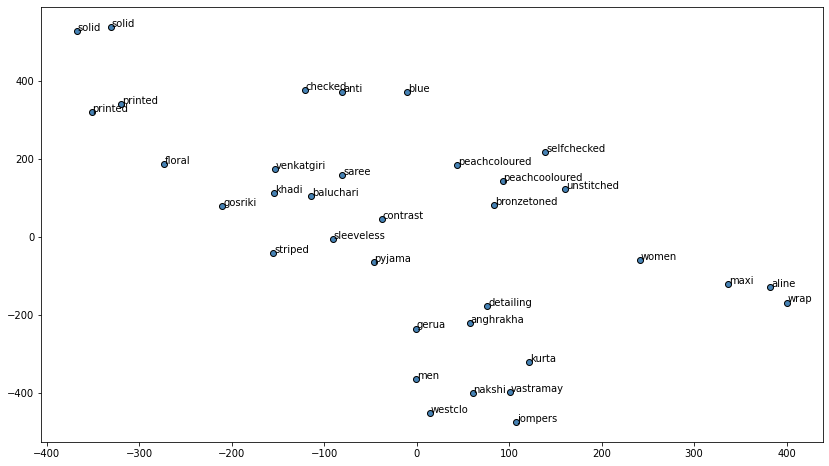

In [ ]:
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
plt.savefig('w1-w1dash.png')